# 投资组合优化

## 引言


无论进行何种投资，一个最基本的问题是投资组合的优化问题，即如何从存款、证券、房地产、外汇、贵金属、电子货币等众多可供投资的理财产品中选择出一部分合适的产品来构建投资组合，并通过调整组合内资产间的比例来达成投资者的投资目标。  

现代投资组合理论（Modern Portfolio theory, MPT）由美国经济学家Harry Markowitz于1952年提出，对投资组合的优化给出了数学上的解决方案，成为了量化投资的基础理论之一。作者因此后来获得了诺贝尔经济学奖。理论指出，通过合理构建投资组合，可以在保证收益的情况下消除一部分投资风险。  

## 简单的理论基础

市场中资产（assest）的价格是由供求关系决定的，并且受到多种复杂因素的共同影响，呈现出一定的波动性。这些影响因素往往可以认为是随机的。中心极限定理表明，随机变量如果是有大量独立的而且均匀的随机变量相加而成，那么它的分布将近似于正态分布。因此，我们可以朴素地认为资产收益(return = price[i] / price[i-1] - 1）将表现出类似正态分布的形式。  

因此，我们就可以使用资产的平均收益（avg(returns)）来衡量一段时间内，资产的收益情况。使用收益的标准差（std(returns))来衡量资产的波动情况，即资产的“风险”。  

现代投资理论假设，一个理性的投资人具有风险规避（risk averse）的倾向，即如果存在两种具有相同期望收益的投资组合，投资者会选择其中风险较小的一种。数学上来说，就是对于给定的收益率，计算投资组合中各项资产的权重w[j]，使得资产组合的风险最小，这是一个最优化问题。  

投资组合的收益  
$R_p=R^Tw$  
方差
$\sigma=w^T\Sigma w$  
其中，$\Sigma$为组合的协方差矩阵

整个问题可以表示为  
$minimize$  
$\quad w^T\Sigma w$  
$subject\ to$  
$\quad R^Tw = \mu$  
$\quad \sum w = 1$  
$\quad w_i \in [0,1]$  
$\mu$为期望收益

这种表示方法的问题在于$\mu$的取值范围难以界定。因此，可以转换为如下公式的形式:

$minimize$  
$\quad w^T\Sigma w - qR^Tw$  
$subject\ to$    
$\quad \sum w = 1$  
$\quad w_i \in [0,1]$  

其中，q的取值范围可以是从0到正无穷，表示投资者对于风险的承受程度。

取不同的$\mu$或者q可以得到在不同的风险偏好下最优组合。这些组合对应的收益和风险可以在收益-风险构成的二维坐标系中构成一条曲线。这条曲线被称为马科维茨效率前缘（Markowitz Efficient Frontier）。

以上最优化问题可以认为是二次规划问题，可以使用python中scipy提供的SLSQP(Sequential Least SQuares Programming)最优化方法求解……

## 仿真数据 
以下是一些代码……

In [6]:
# 导入需要的包
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import scipy.optimize as sco
import math

np.random.seed(123)

In [7]:
# 仿真每日收益

## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

return_vec = np.random.randn(n_assets, n_obs)

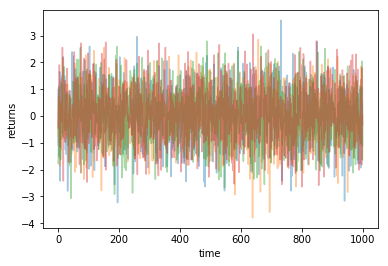

In [8]:
# 日均收益图
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')

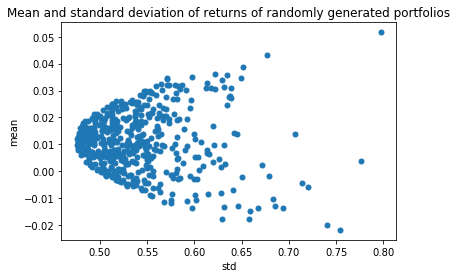

In [9]:
# 随机选择投资权重，在收益-风险坐标系中描点

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)


def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios')

## 求解问题 

$minimize$  
$\quad w^T\Sigma w$  
$subject\ to$  
$\quad R^Tw = \mu$  
$\quad \sum w = 1$  
$\quad w_i \in [0,1]$   

更多的代码……

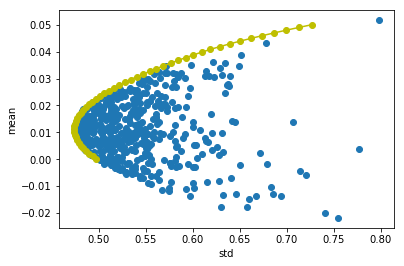

In [5]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    noa = returns.shape[0]
    
    Sigma = np.cov(returns)
    RT = np.mean(returns,axis=1)

    def variance(weights):
        wT = weights.flatten()
        w = wT.T
        risk = wT.dot(Sigma).dot(w)
        return risk

    def day_returns(weights):
        wT = weights.flatten()
        w = wT.T
        ret = RT.dot(w)
        return ret

    #在不同目标收益率水平（target_returns）循环时，最小化的一个约束条件会变化。
    target_returns = np.linspace(0.0,0.05,50)
    target_risks = []
    
    bnds = tuple((0,1) for x in range(noa))

    for tar in target_returns:
        cons = ({'type':'eq','fun':lambda x:day_returns(x)-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
        res = sco.minimize(variance, noa*[1./noa,],method = 'SLSQP', bounds = bnds, constraints = cons)
        target_risks.append(math.sqrt(res['fun']))
        
    target_risks = np.array(target_risks) 
    return target_returns,target_risks
rets,risks = optimal_portfolio(return_vec)
plt.plot(stds, means, 'o')
plt.plot(risks, rets, 'y-o')
plt.xlabel('std')
plt.ylabel('mean')

上图中的黄色曲线就是那个efficient frontier

## 求解问题  

$minimize$  
$\quad w^T\Sigma w - qR^Tw$  
$subject\ to$    
$\quad \sum w = 1$  
$\quad w_i \in [0,1]$  

还是代码……

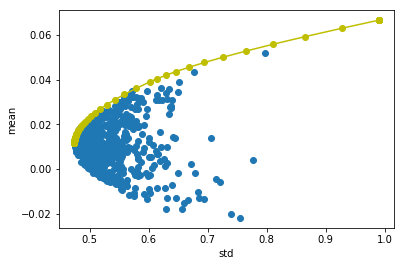

In [6]:
def optimal_portfolio(returns):
    n = returns.shape[1]
    noa = returns.shape[0]
    
    N = 100
    qs = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    Sigma = np.cov(returns)
    RT = np.mean(returns,axis=1)
    
    cons = ({'type':'eq','fun':lambda x:np.sum(x)-1})
    bnds = tuple((0,1) for x in range(noa))
    
    rets = []
    risks = []
    
    def markowitz_loss(weights,q):
        wT = weights.flatten()
        w = wT.T
        loss = wT.dot(Sigma).dot(w) - q * RT.dot(w)
        return loss
        
    for q in qs:
        res = sco.minimize(markowitz_loss, noa*[1./noa,], method='SLSQP', bounds=bnds, constraints=cons, args=(q))
        rets.append(RT.dot(res.x.T))
        risks.append(math.sqrt(res.x.T.dot(Sigma).dot(res.x)))
        
    rets = np.array(rets)
    risks = np.array(risks)
    return rets,risks
rets,risks = optimal_portfolio(return_vec)
plt.plot(stds, means, 'o')
plt.plot(risks, rets, 'y-o')
plt.xlabel('std')
plt.ylabel('mean')

可以看到，这种方法求解的曲线范围更广

In [4]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if not nb_dir in sys.path:
    sys.path.append(nb_dir)
    
from finvest.portfolio_opt import efficient_frontier

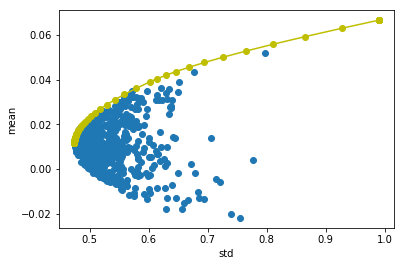

In [11]:
rets,risks = efficient_frontier(return_vec)
plt.plot(stds, means, 'o')
plt.plot(risks, rets, 'y-o')
plt.xlabel('std')
plt.ylabel('mean')